# **자동차 번호판 인식 프로젝트**

## 프로젝트 소개
이 프로젝트는 컴퓨터 비전의 대표적인 응용 중 하나인 **자동차 번호판 인식**을 다룹니다.
OpenCV와 Tesseract OCR을 활용하여 이미지 전처리부터 번호판 영역 검출, 문자 인식까지
전 과정을 직접 구현하는 것이 목표입니다.

### 주요 학습 포인트
1. **이미지 전처리**: 그레이스케일 변환, 이진화, 모폴로지 연산 등을 활용하여 번호판 검출 전처리
2. **번호판 영역 검출**: Contour 기반 검출, 기울어짐(스큐) 보정
3. **문자 인식(OCR)**: Tesseract OCR 라이브러리를 활용한 문자 추출

### 수행 시간
- 총 3시간 내외로 수행할 수 있도록 구성

### 제출물
1. **코드**: 전처리, 번호판 검출, 문자 인식 코드 전부 포함
2. **결과 이미지**: 번호판이 검출된 이미지, 기울기/왜곡이 보정된 이미지, OCR 결과

### 평가 기준
1. **코드 실행 가능성(60%)**: 오류 없이 정상 동작, 파이프라인 전체 구현 여부
2. **결과물 품질(40%)**: 번호판 검출 정확도, 문자 인식 정확도

이제 아래 노트북의 셀을 순서대로 실행하며 과제를 수행하세요.
빈칸(`### TODO:` 표시)을 채우고 필요한 부분을 구현하면 됩니다.

## 1. 환경 세팅

Colab에서 아래 라이브러리들을 사용하기 위해서는 설치가 필요할 수 있습니다.
만약 이미 설치되어 있다면 재설치는 생략 가능합니다.

- OpenCV
- Tesseract (OCR)
- PyTesseract (Python Wrapper)

아래 셀을 통해 필요한 라이브러리를 설치하십시오. Colab 환경에서는 `apt` 및 `pip` 명령을 이용해 설치할 수 있습니다.

In [9]:
### TODO: 필요한 라이브러리 설치
# 예시:
# !pip install opencv-python pytesseract
# !sudo apt-get install tesseract-ocr

!pip install opencv-python
!pip install pytesseract
!sudo apt-get install tesseract-ocr
pass

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


## 2. 라이브러리 임포트
이미지 처리와 과제 수행에 필요한 라이브러리를 불러옵니다.
- **OpenCV**: 영상 처리
- **matplotlib**: 이미지 시각화
- **numpy**: 행렬/배열 연산
- **pytesseract**: 문자 인식 (OCR)

In [10]:
### TODO: 필요한 라이브러리를 임포트하세요.
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from google.colab.patches import cv2_imshow

# Google Colab 상에서 시각화가 잘 보이도록 설정
%matplotlib inline

print("OpenCV version:", cv2.__version__)
print("pytesseract version:", pytesseract.__version__)


OpenCV version: 4.10.0
pytesseract version: 0.3.13


## 3. 이미지 업로드 및 읽기
Colab에서 직접 이미지를 업로드하여 사용할 수 있습니다. 다음 방법 중 하나를 선택해서 이미지를 불러오세요.

1. Colab에 직접 업로드
2. 구글 드라이브와 연동
3. 인터넷에 공개된 이미지를 `cv2.VideoCapture()` 또는 `urllib` 등을 통해 가져오기

번호판이 보이는 자동차 이미지를 `img` 변수에 저장하고, 아래 코드 셀에 불러와 확인합니다.

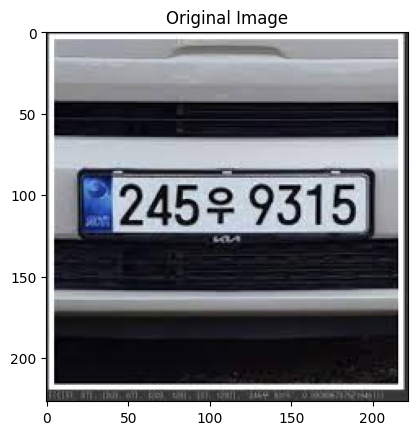

In [11]:
### TODO: 자동차 이미지 불러오기
from google.colab import files
uploaded = files.upload()
# 예시) Colab에 이미지 업로드 후 해당 파일명을 사용
# uploaded = files.upload()  # 파일 업로드 창이 뜸
# img = cv2.imread('car_plate.jpg')  # 업로드한 파일 이름 사용

# 아래는 예시입니다. 여러분의 이미지 파일명을 넣어주세요.
# img = cv2.imread('car_plate.jpg')

### 임시로 img를 None으로 두었습니다.
img = cv2.imread('images.jfif')  # 실제 과제 수행 시, 여기에 적절한 이미지를 읽어오도록 수정하세요.

if img is None:
    print("이미지가 정상적으로 불러와지지 않았습니다. 경로를 확인하세요.")
else:
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title('Original Image')
    plt.show()

## 4. 이미지 전처리
번호판 영역을 검출하기 전, 이미지의 노이즈를 제거하고 특징을 강화하기 위한 여러 가지 방법을 적용합니다.

1. **그레이스케일 변환**
2. **이진화 (Thresholding)**
3. **모폴로지 연산 (침식, 팽창, 열기, 닫기 등)**
4. **엣지 검출 (선택적)**: Canny 알고리즘을 활용

아래 셀에 전처리 과정들을 단계별로 구현해보세요.

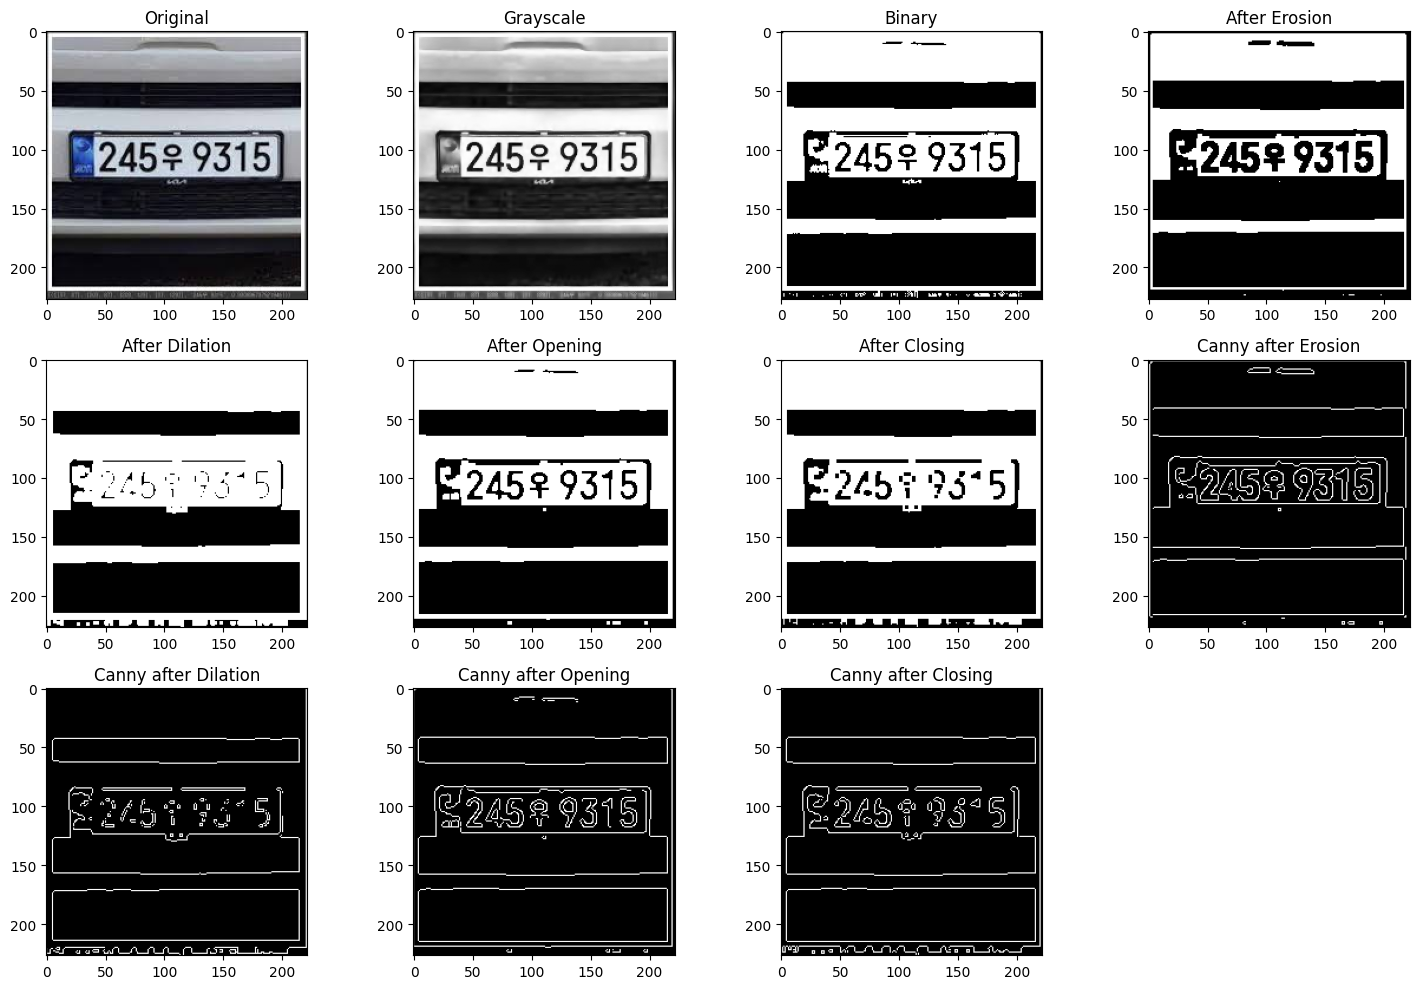

In [12]:
def preprocess_image(image):
    """
    입력: RGB/BGR 이미지
    출력: 전처리가 완료된 이진화 이미지(binary), 중간에 필요한 결과도 반환해도 좋음
    """
    # 1. 그레이스케일 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 2. 노이즈 제거 및 엣지 보존
    gray = cv2.bilateralFilter(gray, 5, 30, 30)

    # 3. 대비 향상
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(15,15))
    gray = clahe.apply(gray)

    # 4. 이진화 (Otsu's Thresholding)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 5. 모폴로지 연산
    kernel = np.ones((3, 3), np.uint8)

    # 4가지 모폴로지 연산 수행
    morphology_results = {
        'Erosion': cv2.erode(binary, kernel, iterations=1),
        'Dilation': cv2.dilate(binary, kernel, iterations=1),
        'Opening': cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel),
        'Closing': cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    }

    # 6. Canny 엣지 검출
    edges_results = {name: cv2.Canny(morph, 100, 200)
                    for name, morph in morphology_results.items()}

    return gray, binary, morphology_results, edges_results

# 전처리 테스트
if img is not None:
    # 전처리 수행
    gray, binary, morphology_results, edges_results = preprocess_image(img)

    # 결과 시각화
    plt.figure(figsize=(15, 10))

    # 원본 이미지
    plt.subplot(3, 4, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original')

    # 그레이스케일
    plt.subplot(3, 4, 2)
    plt.imshow(gray, cmap='gray')
    plt.title('Grayscale')

    # 이진화
    plt.subplot(3, 4, 3)
    plt.imshow(binary, cmap='gray')
    plt.title('Binary')

    # 각 모폴로지 연산 결과
    for idx, (name, result) in enumerate(morphology_results.items(), 4):
        plt.subplot(3, 4, idx)
        plt.imshow(result, cmap='gray')
        plt.title(f'After {name}')

    # 각 Canny 엣지 결과
    for idx, (name, edges) in enumerate(edges_results.items(), 8):
        plt.subplot(3, 4, idx)
        plt.imshow(edges, cmap='gray')
        plt.title(f'Canny after {name}')

    plt.tight_layout()
    plt.show()

## 5. 번호판 영역 검출
전처리된 이진 이미지에서 번호판으로 추정되는 영역을 찾습니다.

### 방법
1. **Contours**: `cv2.findContours()`를 사용하여 윤곽선을 검출합니다.
2. 윤곽선의 **Bounding Box**를 구하여, 가로세로 비율(aspect ratio) 등을 활용해 번호판으로 추정되는 영역을 선별합니다.
3. 회전이나 왜곡이 심한 경우, 추가적으로 **기울기 보정** (또는 **퍼스펙티브 변환**)을 적용할 수 있습니다.


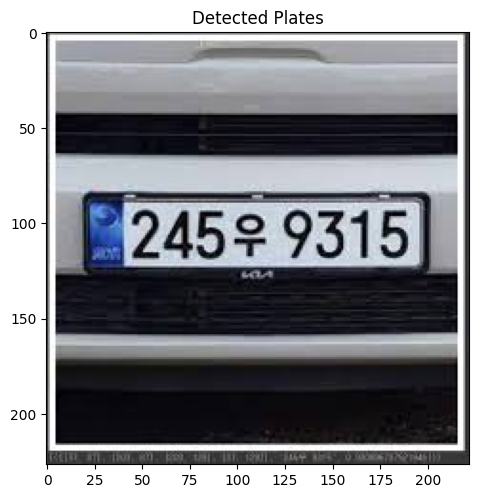

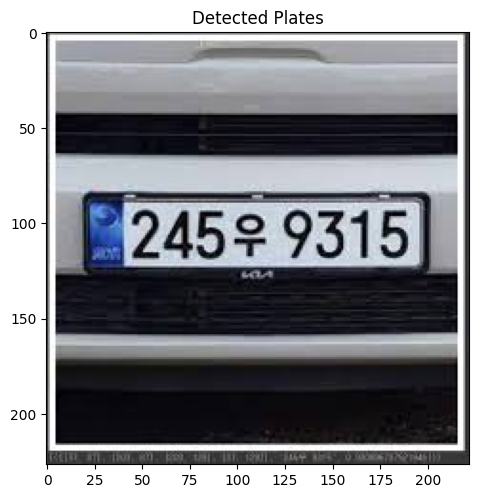

In [13]:
### TODO: 번호판 영역 검출
def detect_plate_areas(image, binary_image):
    """
    입력:
        image: 원본 컬러 이미지
        binary_image: 전처리된 이진 이미지
    출력:
        plates: 검출된 번호판 영역(잘라낸 이미지)들의 리스트
        plate_coords: 각 번호판의 좌표 정보 (x, y, w, h)
    """
    plates = []
    plate_coords = []

    ### 1) 컨투어 검출
    contours, hierarchy = cv2.findContours(
        binary_image,
        cv2.RETR_TREE,
        cv2.CHAIN_APPROX_SIMPLE
    )

    ### 2) 컨투어 순회하며 번호판 후보 영역 찾기

    for contour in contours:
      x,y,w,h = cv2.boundingRect(contour)
      area = w*h
      if w/h > 2 and w/h < 3.5 and area > 30000:
        plates.append(binary_image[y:y+h, x:x+w])
        plate_coords.append((x,y,w,h))

    return plates, plate_coords

# 테스트
if img is not None:
    gray, binary, morphology_results, edges_results = preprocess_image(img)
    detected_plates, coords = detect_plate_areas(img, morphology_results['Opening'])
    detected_plates2, coords2 = detect_plate_areas(img, morphology_results['Erosion'])

    img_copy = img.copy()
    for i, (x, y, w, h) in enumerate(coords):
        cv2.rectangle(img_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # 시각화
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    plt.title('Detected Plates')

    if len(detected_plates) > 0:
        plt.subplot(1, 2, 2)
        plt.imshow(detected_plates[0])
        plt.title('Sample Plate')
    plt.show()

    for i, (x, y, w, h) in enumerate(coords):
        cv2.rectangle(img_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # 시각화
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    plt.title('Detected Plates')

    if len(detected_plates) > 0:
        plt.subplot(1, 2, 2)
        plt.imshow(detected_plates2[0])
        plt.title('Sample Plate')
    plt.show()

## 6. 기울기 보정 (스큐 보정) 및 퍼스펙티브 보정
번호판이 기울어지거나(스큐) 원근으로 인해 사다리꼴 형태로 보이는 경우,
**허프 선 변환**(Hough Transform)이나 **모서리 검출**을 통해 각도를 계산하고,
OpenCV의 **회전 변환**(Rotation) 또는 **퍼스펙티브 변환**(Perspective Transform)을 적용할 수 있습니다.

아래 셀은 예시 코드 골격만 제시합니다. 필요 시 직접 구현하거나,
간단한 각도 계산 정도만 수행해 보세요.

```
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(plate_img, M, (w, h))
```


In [14]:
### TODO: 기울어진 번호판 보정(필요 시)
def correct_skew(plate_img):
    """
    입력: 번호판 이미지
    출력: 기울기/왜곡이 보정된 번호판 이미지
    """
    m = cv2.moments(plate_img)
    angle = 0.5 * np.arctan2(2*m['mu11'], abs(m['mu02']-m['mu20'])) * 180 / np.pi
    center = (plate_img.shape[1] // 2, plate_img.shape[0] // 2)

    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    img_out = cv2.warpAffine(plate_img, M, (plate_img.shape[1], plate_img.shape[0]))

    return img_out

# 간단 테스트
if img is not None:
    if len(detected_plates) > 0:
        test_plate = detected_plates[0]
        fixed_plate = correct_skew(test_plate)

        test_plate2 = detected_plates2[0]
        fixed_plate2 = correct_skew(test_plate2)

        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1)
        plt.imshow(cv2.cvtColor(test_plate, cv2.COLOR_BGR2RGB))
        plt.title('Original Plate')

        plt.subplot(1,2,2)
        plt.imshow(cv2.cvtColor(fixed_plate, cv2.COLOR_BGR2RGB))
        plt.title('Corrected Plate')
        plt.show()

        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1)
        plt.imshow(cv2.cvtColor(test_plate2, cv2.COLOR_BGR2RGB))
        plt.title('Original Plate')

        plt.subplot(1,2,2)
        plt.imshow(cv2.cvtColor(fixed_plate2, cv2.COLOR_BGR2RGB))
        plt.title('Corrected Plate')
        plt.show()

## 7. 문자 인식 (OCR)
번호판 영역을 잘라낸 뒤, Tesseract OCR을 이용해 텍스트(숫자/문자)를 인식합니다.

### Tesseract 사용법
```python
import pytesseract
text = pytesseract.image_to_string(cropped_plate, config='--psm 8')
```
config 파라미터를 적절히 조정하여 인식률을 높일 수 있습니다. (예: `--oem 3 --psm 6` 등)

이미지를 명확히 하기 위해 추가적인 전처리(이진화, 크기 조정, 대비 증가 등)를 할 수도 있습니다.

In [15]:
### TODO: OCR 적용
def recognize_text_from_plate(plate_img):
    """
    입력: 번호판 이미지
    출력: 인식된 문자열
    """
    # OCR을 위한 그레이스케일, 이진화 등 추가 전처리를 여기서 해도 좋습니다.
    kernel_3 = np.ones((3,3), np.uint8)

    plate_img = cv2.erode(plate_img, kernel_3, iterations=3)
    plate_img = cv2.pyrDown(plate_img)
    plate_img = cv2.Canny(plate_img, 0, 100)
    plt.imshow(plate_img)
    text = pytesseract.image_to_string(plate_img, config='--psm 8')


    return text

# 테스트
if img is not None and len(detected_plates) > 0:
    for i, plate in enumerate(detected_plates2):
        corrected = correct_skew(plate)
        recognized_text = recognize_text_from_plate(corrected)
        print(f"Plate {i} -> Detected Text: {recognized_text}")
else:
    print("이미지가 없거나 번호판이 검출되지 않았습니다.")

이미지가 없거나 번호판이 검출되지 않았습니다.


## 8. 과제 마무리
이제 전체 과정을 통해 자동차 번호판을 인식하는 파이프라인을 구축하였습니다.

### 포함할 내용
1. **프로젝트 개요**: 문제 정의와 접근 방법
2. **구현 상세**: 각 단계(전처리, 검출, 보정, OCR)에서 사용한 기법과 이유
3. **결과물**: 번호판 검출된 이미지, 기울기 보정 전후 이미지, 최종 OCR 결과
4. **분석 및 개선 방안**
   - OCR 인식률이 떨어진 원인
   - 모폴로지 연산 파라미터, 임계값 조절 등에 대한 피드백
   - 배경 잡음이 심할 때는 어떻게 개선?

이 노트북에서 각 단계를 자유롭게 수정/개선하며 진행해보세요.